In this tutorial, we will cover how to import and run an environment for RL training using OpenAI Gym. We will also look at how well an RL agent trained on this environment to do a specific task performs, compared to an agent taking random actions in the environment.



In [ ]:
#Installing packages for rendering the game on Colab
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

# **Setting up the environment**

Any new RL algorithm that is developed will need to be benchmarked and compared against state-of-the-art RL algorithms. A variety of benchmarks exist for various types of tasks and various specific domains eg. robot locomotion. 

While the final aim is to run such algorithms in the real world eg. controlling a quadruped robot to jump over obstacles, for practicality and reduced costs during development, it is more convenient to use benchmarks that allow virtual simulations of these real-world tasks. A few examples of these are MuJoCo (Multi-Joint dynamics with Contact), StarCraft2 and Atari.

OpenAI Gym aims to provide an easy-to-setup general-intelligence benchmark with a wide variety of different environments. The goal is to standardize how environments are defined in AI research publications so that published research becomes more easily reproducible. 

**Import OpenAI gym**

In [ ]:
import gym

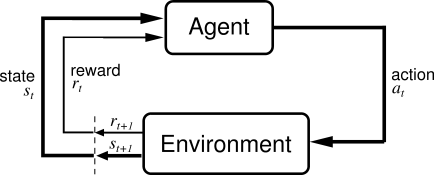



Consider an RL agent that interacts with its environment in discrete timesteps. For every discrete time step, the agent perceives the state **s<sub>t</sub>** of its environment and chooses an action **a<sub>t</sub>** according to its **policy**. The agent then receives a reward **r<sub>t+1</sub>** for its action and the environment transitioned into the next state **s<sub>t+1</sub>**. We now show how to set up such an environment using OpenAI gym

Some helpful terminology:
* **Episode** - A collection of steps that terminates when the agent fails to achieve the goal, or the episode reaches the maximum number of allowed steps.
* **Render** - Gym can render one frame for display after each episode.
* **Nondeterministic** - For some environments, randomness is a factor in deciding what effects actions have on reward and changes to the observation space.

In [ ]:
env = gym.make('CartPole-v1')

We just created an instance of the CartPole-v1 environment. 

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.


Now let's take a deeper look at some of the environment specifics:
* **action space**: What actions can we take on the environment, at each step/episode, to alter the environment.
* **observation space**: What is the current state of the portion of the environment that we can observe.


In [ ]:
def query_environment(env, name):
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")

In [ ]:
query_environment(env, 'CartPole-v1')

Action Space: Discrete(2)
Observation Space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max Episode Steps: 500
Nondeterministic: False
Reward Range: (-inf, inf)


 The environment has an observation space of 4 continuous numbers:

* Cart Position
* Cart Velocity
* Pole Angle
* Pole Velocity At Tip

To achieve this goal, the agent can take the following actions:

* Push cart to the left
* Push cart to the right


# **Interacting with the environment**

To make things clearer, let us now see how the agent can interact with the environment:

**Getting the observation**

(Every episode of training starts with env.reset(), to reset the simulation to the starting state or states)

In [ ]:
observation = env.reset()
print("Observation:", observation)

Observation: [-0.01436883  0.00595485 -0.00164396  0.04655107]


**Choosing an action**

In [ ]:
action = env.action_space.sample()
print("Action chosen:",action)

Action chosen: 0


**Performing an environment step**

In [ ]:
next_observation, reward, done, _ = env.step(action) 
print("Next observation", next_observation)
print("Reward obtained", reward)
print("Does the state-action pair lead to a terminal state?", done)

Next observation [-0.01424973 -0.18914349 -0.00071293  0.33871486]
Reward obtained 1.0
Does the state-action pair lead to a terminal state? False


**A few functions for rendering an episode on Google Colab and plotting rewards**

In [ ]:

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def plot_rewards(rewards, q, title):

    avg_rew = []
    j = 0
    
    while(j < len(rewards) - q):
      
      x = rewards[j:j+q]
      sum1 = np.sum(np.array(x)) /q
      avg_rew.append(sum1)
      j = j+1


    plt.suptitle(title)
    plt.plot(avg_rew)
    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.show()  

**Task 1: Putting it all together - Episodes with a random agent**



**Part 1**: Your task will be to run an episode of simulation with an agent following a random policy. After every 10 steps of the episode, **you are to print the step reward r as well as the cumulative reward from the beginning of the episode**. Complete the code and run the function to render the episode. The function returns the cumulative reward.

In [ ]:
def simulate_episode(env, wrap = False, render = False, video = False, log = False): #if log==True, print the step reward and cumulative reward
    
    if(wrap):
      env = wrap_env(env) #This is purely for rendering
    
    observation = env.reset() #initial observation
    cumulative_reward = 0

    while True:

        #Rendering function  
        if(render):
          env.render()
        
        #take an action, take a step and continue the episode if the next state is not terminal. Print required data every 10 steps
        action = env.action_space.sample()
        next_observation, reward, done, _ = env.step(action) 
        if done:
          break
        cumulative_reward += reward
        if log:
          if not cumulative_reward%10 and not done:
            print('Step reward: ', reward)
            print('Cumulative reward: ', cumulative_reward) 

    env.close()
    if(video):
      show_video()
    return cumulative_reward  

In [ ]:
total_rew = simulate_episode(env, wrap = True, render = True, video = True, log = True)
print("Cumulative reward on episode termination", total_rew)

Step reward:  1.0
Cumulative reward:  10.0
Step reward:  1.0
Cumulative reward:  20.0


Cumulative reward on episode termination 24.0


**Part 2**: Using the function you just wrote, run a loop to simulate 1000 episodes of training and plot the cumulative reward vs episodes graph

In [ ]:
rewards = []
ep = 0
while (ep < 1000):
   total_rew = simulate_episode(env, wrap = False, render = False, video = False, log = False)
   rewards.append(total_rew)
   ep += 1
env.close()

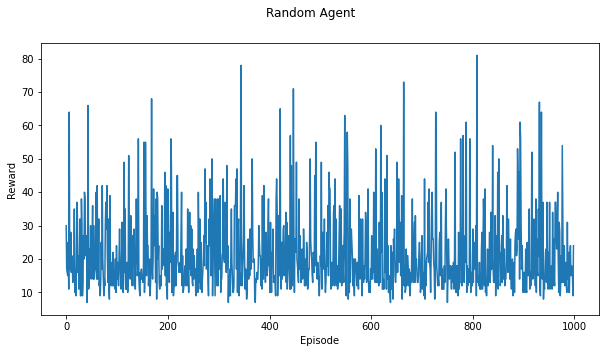

In [ ]:
plt.figure(figsize=(10, 5))
plot_rewards(rewards, 1, "Random Agent")

# **Deep RL Agent**

Now that we know how to import an environment and use it, let us see how a deep RL agent trained on this task performs.

Specifically, we use a Deep Q Network (DQN) to train our CartPole agent to navigate towards its goal. Broadly speaking, every RL algorithm performs an agent in two stages performed repeatedly till the task is performed optimally:



1.   Collect episodes of data by interacting with the environment.
2.   Learn to perform the task better, using the collected data.



We do not get into further specifics of training the agent yet. This will covered in detail in future tutorials


**How well does the DQN agent perform on the same task?**

In [ ]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4             # learning rate 
UPDATE_EVERY = 10        # how often to update the network (When Q target is present)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
### Q NETWORK ARCHITECTURE
'''
QNetwork:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 64 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
class Agent():
    """
    CASE 1 -
    +Q => Q-Targets
    +E => Experience Replay
    +T => Truncation
    """

    def __init__(self, state_size, action_size, seed):

        # Agent Environment Interaction
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        # Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):

        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # If enough samples are available in memory, get random subset and learn
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        # Updating the Network every 'UPDATE_EVERY' steps taken       
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        

        # Minimize the loss
        self.optimizer.zero_grad()
        loss = F.mse_loss(Q_expected, Q_targets)
        loss.backward()
        
        #Gradient Clipping
        """ +T TRUNCATION PRESENT """
        # for param in self.qnetwork_local.parameters():
        #     param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()

In [ ]:
# REPLAY BUFFER

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [ ]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.995):

    scores = []                 # list containing scores from each episode
    rewards = []
    scores_window_printing = deque(maxlen=10) # For printing in the graph
    scores_window= deque(maxlen=100)  # last 100 scores for checking if the avg is more than 195
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        rewards.append(score) 
        if(len(rewards)%500==0):
                 plt.figure(figsize=(10, 5))
                 plot_rewards(rewards, 1, "DQN")
        scores_window.append(score)       # save most recent score
        scores_window_printing.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  
        if i_episode % 10 == 0: 
            scores.append(np.mean(scores_window_printing))        
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # if np.mean(scores_window)>=195.0:
        #   print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        #   break
    return rewards, [np.array(scores),i_episode-100]

**Training the DQN agent**

In [ ]:
# Playing the game
env = gym.make('CartPole-v1')
env.seed(0)
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

# Trial run to check if algorithm runs and saves the data
begin_time = datetime.datetime.now()
agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0)
rewards,_ = train(n_episodes=200)
time_taken = datetime.datetime.now() - begin_time
print(time_taken)

Episode 100	Average Score: 34.61
Episode 200	Average Score: 155.02
0:01:22.011143


**Plotting the training curve of the DQN agent**

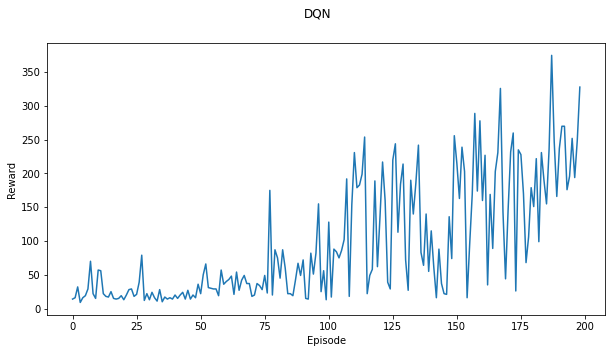

In [ ]:
plt.figure(figsize=(10, 5))
plot_rewards(rewards, 1, "DQN")

**Task 2: Rendering an episode with the trained DQN agent**

Your task will be to run an episode of simulation with the DQN agent. After every 50 steps of the episode, **you are to print the step reward r as well as the cumulative reward from the beginning of the episode**. Complete the code and run the function to render the episode. The function returns the cumulative reward

In [ ]:
print(agent.act(env.reset()))

0


In [ ]:
def simulate_episode_dqn(env, wrap = False, render = False, video = False, log = False): #if log==True, print the step reward and cumulative reward
    
    if(wrap):
      env = wrap_env(env) 

    obs = env.reset()
    cumulative_reward = 0
    
    while True:
      #Rendering function  
        if(render):
          env.render()
        
        #take an action, take a step and continue the episode if the next state is not terminal. Print required data every 50 steps
        action = agent.act(obs)
        obs, reward, done, _ = env.step(action) 
        if done:
          break
        cumulative_reward += reward
        if log:
          if not cumulative_reward%50 and not done:
            print('Step reward: ', reward)
            print('Cumulative reward: ', cumulative_reward)
                  
    env.close()
    if(video):
      show_video()
    return cumulative_reward

In [ ]:
#Make environment
total_rew = simulate_episode_dqn(env, wrap = True, render = True, video = True, log = True)
print("Cumulative reward after episode termination", total_rew)

Step reward:  1.0
Cumulative reward:  50.0
Step reward:  1.0
Cumulative reward:  100.0
Step reward:  1.0
Cumulative reward:  150.0
Step reward:  1.0
Cumulative reward:  200.0
Step reward:  1.0
Cumulative reward:  250.0
Step reward:  1.0
Cumulative reward:  300.0


Cumulative reward after episode termination 314.0


## ------------------ **THANK YOU** ------------------- 